In [2]:
import os
import gc
import sys
import warnings
import pickle
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df_names = ['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events',
           'games', 'standings', 'rosters', 'transactions']
path = "data/train_vs/"

train_dict = {}
for index in range(len(df_names)):
    train_dict[df_names[index]] = pd.read_pickle(os.path.join(path,df_names[index]) + "_train.pkl")

In [4]:
df_names = ['seasons', 'teams', 'players', 'awards']
path = "data/"

my_dict = {}
for index in range(len(df_names)):
    my_dict[df_names[index]] = pd.read_csv(os.path.join(path,df_names[index]) + ".csv")

In [5]:
target_v = pd.read_pickle('data/target_v/nextDayPlayerEngagement_train.pkl')

In [6]:
target_dict = {id: target_v[target_v['playerId']==id].drop(
    ['index'], axis = 1) for id in target_v['playerId'].unique()}    

In [7]:
target_dict[112526].head(3)

,engagementMetricsDate,playerId,target1,target2,target3,target4,date
969,2018-01-02,112526,0.055277,5.496109,0.025839,16.176471,20180101
3556,2018-01-03,112526,0.060625,3.252914,0.030486,8.541353,20180102
5737,2018-01-04,112526,0.029341,1.648352,0.032613,10.490112,20180103


## Dictionary for playerBoxScores

In [194]:
perform_stats = pd.DataFrame()
perform_stats = train_dict['playerBoxScores'][[
    'playerId', 'gamePk', 'gameDate', 'gameTimeUTC', 'teamId', 'date']]
perform_stats.head(3)

,playerId,gamePk,gameDate,gameTimeUTC,teamId,date
0,605131,529418,2018-03-29,2018-03-29T23:08:00Z,119,20180329
1,605480,529406,2018-03-29,2018-03-29T20:00:00Z,139,20180329
2,546318,529416,2018-03-29,2018-03-29T20:10:00Z,143,20180329


In [195]:
warnings.simplefilter("ignore")

In [196]:
performance = train_dict['playerBoxScores']

# Defense
perform_stats['FPCT'] = (performance['putOuts']+performance['assists']) / performance['chances']
perform_stats['Out'] = performance['putOuts'] + performance['groundOuts'] + performance['strikeOuts'] + performance['flyOuts']

# Offence
perform_stats['AB'] = performance['atBats']
perform_stats['B2'] = performance['doubles']
perform_stats['B3'] = performance['triples']
perform_stats['SB'] = performance['stolenBases']
perform_stats['CS'] = performance['caughtStealing']
perform_stats['H'] = performance['hits']
perform_stats['HR'] = performance['homeRuns']
perform_stats['IBB'] = performance['intentionalWalks']
perform_stats['HBP'] = performance['hitByPitch']
perform_stats['LOB'] = performance['leftOnBase']
perform_stats['PA'] = performance['plateAppearances']
perform_stats['TB'] = performance['totalBases']
perform_stats['GIDP'] = performance['groundIntoDoublePlay']
perform_stats['RBI'] = performance['rbi']
perform_stats['BB'] = performance['baseOnBalls']
perform_stats['SO'] = performance['strikeOuts']
perform_stats['AVG'] = perform_stats['H']/perform_stats['AB']


# Pitching
perform_stats['SV_percnt'] = performance['saves']/performance['saveOpportunities']
perform_stats['HLD'] = performance['holds']
perform_stats['BS'] = performance['blownSaves']
perform_stats['IR'] = performance['inheritedRunners']
perform_stats['IP'] = performance['inningsPitched']
perform_stats['ERA'] = (9*performance['earnedRuns'])/perform_stats['IP']
perform_stats['WHIP'] = (perform_stats['BB'] + perform_stats['H'])/perform_stats['IP']

# Advanced Offence
perform_stats['ISO'] = (perform_stats['B2']+2*perform_stats['B3']+3*perform_stats['HR'])/perform_stats['AB']
perform_stats['BABIP'] = (perform_stats['H'] - perform_stats['HR'])/(
    perform_stats['AB']-perform_stats['SO']-perform_stats['HR']+performance['sacFlies'])
perform_stats['RC'] = perform_stats['TB']*(perform_stats['H']+perform_stats['BB'])/(
    perform_stats['AB']+perform_stats['BB'])

perform_stats['PA/SO'] = perform_stats['PA']/perform_stats['SO']
perform_stats['K/BB'] = perform_stats['SO']/perform_stats['BB']

perform_stats['GS'] = 40+6*perform_stats['Out']+perform_stats['SO']-2*performance['baseOnBallsPitching']-2*performance['hitsPitching']-3*performance['runsPitching']-6*performance['homeRunsPitching']

In [197]:
select_perform = perform_stats[['playerId', 'gamePk', 'gameDate', 'gameTimeUTC', 'teamId', 'date', 'CS', 'IBB',
                                'HBP','LOB', 'PA', 'TB', 'GIDP', 'RBI', 'BB', 'SO', 'AVG', 'SV_percnt', 'HLD','BS', 'IR', 
                                'IP', 'ERA', 'WHIP', 'ISO', 'BABIP', 'RC', 'PA/SO', 'K/BB', 'GS']]

In [198]:
playerBS_dict = {id: select_perform[select_perform['playerId']==id] for id in target_v['playerId'].unique()}    

In [199]:
merge_1  = {}
for key, df in target_dict.items():
    df = target_dict[key].merge(playerBS_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_1[key] = df

In [200]:
train_dict.keys()

dict_keys(['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events', 'games', 'standings', 'rosters', 'transactions'])

In [201]:
# train_dict['teamBoxScores'].columns

In [202]:
select_awards = train_dict['awards'][['playerId', 'date', 'awardId']]

In [203]:
awards_dict = {id: select_awards[select_awards[
    'playerId']==id] for id in target_v['playerId'].unique()}    

In [204]:
merge_2  = {}
for key, df in target_dict.items():
    df = merge_1[key].merge(awards_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_2[key] = df

In [205]:
select_stand = train_dict['standings'][['gameDate', 'divisionId', 'teamId', 'divisionRank', 'leagueRank', 'wildCardRank', 
                                         'pct', 'homeWins', 'xWinLossPct', 'date']]

In [206]:
# train_dict['standings'].head()
merge_3  = {}
for key, df in target_dict.items():
    df = merge_2[key].merge(select_stand, on = ['date', 'teamId', 'gameDate'], how = 'left')
    merge_3[key] = df

In [207]:
select_rosters = train_dict['rosters'].drop(['status', 'index'], axis = 1)

In [208]:
rosters_dict = {id: select_rosters[select_rosters['playerId']==id] for id in target_v['playerId'].unique()}

In [209]:
merge_4  = {}
for key, df in target_dict.items():
    df = merge_3[key].merge(rosters_dict[key], on = ['date', 'playerId', 'teamId', 'gameDate'], how = 'left')
    merge_4[key] = df

In [210]:
select_games = train_dict['games'][['gamePk', 'gameType', 'gameTimeUTC', 'codedGameState', 'gameNumber',
                                   'homeId', 'homeWinPct', 'homeScore',]]

In [211]:
merge_5  = {}
for key, df in target_dict.items():
    df = merge_4[key].merge(select_games, on = ['gameTimeUTC', 'gamePk'], how = 'left')
    merge_5[key] = df

In [212]:
team_stats = pd.DataFrame()
performance_team = train_dict['teamBoxScores']
team_stats['Out_team'] = performance_team['groundOuts'] + performance_team['strikeOuts'] + performance_team['flyOuts']

# Offence
team_stats['AB_team'] = performance_team['atBats']
team_stats['B2_team'] = performance_team['doubles']
team_stats['B3_team'] = performance_team['triples']
team_stats['SB_team'] = performance_team['stolenBases']
team_stats['CS_team'] = performance_team['caughtStealing']
team_stats['H_team'] = performance_team['hits']
team_stats['HR_team'] = performance_team['homeRuns']
team_stats['IBB_team'] = performance_team['intentionalWalks']
team_stats['HBP_team'] = performance_team['hitByPitch']
team_stats['LOB_team'] = performance_team['leftOnBase']
team_stats['PA_team'] = performance_team['plateAppearances']
team_stats['TB_team'] = performance_team['totalBases']
team_stats['GIDP_team'] = performance_team['groundIntoDoublePlay']
team_stats['RBI_team'] = performance_team['rbi']
team_stats['BB_team'] = performance_team['baseOnBalls']
team_stats['SO_team'] = performance_team['strikeOuts']
team_stats['AVG_team'] = team_stats['H_team']/team_stats['AB_team']


# Pitching
team_stats['IR_team'] = performance_team['inheritedRunners']
team_stats['IP_team'] = performance_team['inningsPitched']
team_stats['ERA_team'] = (9*performance_team['earnedRuns'])/team_stats['IP_team']
team_stats['WHIP_team'] = (team_stats['BB_team'] + team_stats['H_team'])/team_stats['IP_team']

# Advanced Offence
team_stats['ISO_team'] = (team_stats['B2_team']+2*team_stats['B3_team']+3*team_stats['HR_team'])/team_stats['AB_team']
team_stats['BABIP_team'] = (team_stats['H_team'] - team_stats['HR_team'])/(
    team_stats['AB_team']-team_stats['SO_team']-team_stats['HR_team']+performance_team['sacFlies'])
team_stats['RC_team'] = team_stats['TB_team']*(team_stats['H_team']+team_stats['BB_team'])/(
    team_stats['AB_team']+team_stats['BB_team'])

team_stats['PA/SO_team'] = team_stats['PA_team']/team_stats['SO_team']
team_stats['K/BB_team'] = team_stats['SO_team']/team_stats['BB_team']

In [213]:
team_stats['Pytha_WR'] = train_dict['teamBoxScores']['runsScored']**2/(
    train_dict['teamBoxScores']['runsScored']**2 + train_dict['teamBoxScores']['runsPitching']**2)

In [214]:
team_stats.replace(np.inf, 0, inplace=True)

In [215]:
team_stats[['teamId', 'gamePk', 'gameDate', 'gameTimeUTC', 'date']] = train_dict['teamBoxScores'][[
    'teamId', 'gamePk', 'gameDate', 'gameTimeUTC', 'date']]

In [216]:
select_teamstat = team_stats[['IBB_team', 'HBP_team', 'LOB_team', 'PA_team',
       'TB_team', 'GIDP_team', 'RBI_team', 'AVG_team',
       'IR_team', 'IP_team', 'ERA_team', 'ISO_team', 'BABIP_team', 'RC_team',
       'PA/SO_team', 'K/BB_team', 'Pytha_WR', 'teamId', 'gamePk', 'gameDate',
       'gameTimeUTC', 'date']]

In [217]:
merge_6  = {}
for key, df in target_dict.items():
    df = merge_5[key].merge(select_teamstat, on = ['gamePk', 'gameDate', 'gameTimeUTC','teamId', 'date'], how = 'left')
    merge_6[key] = df

In [218]:
select_playtwt = train_dict['playerTwitterFollowers'][['date', 'playerId', 'numberOfFollowers']]

playtwt_dict = {id: select_playtwt[select_playtwt['playerId']==id] for id in target_v['playerId'].unique()}    

In [219]:
merge_7  = {}
for key, df in target_dict.items():
    df = merge_6[key].merge(playtwt_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_7[key] = df

In [220]:
select_playtwt = train_dict['teamTwitterFollowers'][['date', 'teamId', 'numberOfFollowers']]

merge_8  = {}
for key, df in target_dict.items():
    df = merge_7[key].merge(select_playtwt, on = ['date', 'teamId'], how = 'left')
    merge_8[key] = df

In [221]:
# train_dict['events'].columns

In [222]:
# select_events = train_dict['events'][['gamePk', 'gameDate', 'gameTimeUTC','gameType', 'eventId', 
#                                       'inning', 'halfInning', 'homeScore', 'pitcherTeamId', 
#                                      'hitterTeamId', 'pitchType', 'pitchType', 'date']]

In [223]:
# merge_6  = {}
# for key, df in target_dict.items():
#     df = merge_5[key].merge(select_events, on = ['gamePk', 'gameDate', 'gameTimeUTC','gameType'], how = 'left')
#     merge_6[key] = df

## Construct whole df

In [224]:
df = pd.concat(merge_8.values() ,axis=0)

In [225]:
df = df.drop(['gamePk', 'gameDate', 'gameTimeUTC', 'engagementMetricsDate'], axis = 1)

In [226]:
df.columns

Index(['playerId', 'target1', 'target2', 'target3', 'target4', 'date',
       'teamId', 'CS', 'IBB', 'HBP', 'LOB', 'PA', 'TB', 'GIDP', 'RBI', 'BB',
       'SO', 'AVG', 'SV_percnt', 'HLD', 'BS', 'IR', 'IP', 'ERA', 'WHIP', 'ISO',
       'BABIP', 'RC', 'PA/SO', 'K/BB', 'GS', 'awardId', 'divisionId',
       'divisionRank', 'leagueRank', 'wildCardRank', 'pct', 'homeWins',
       'xWinLossPct', 'statusCode', 'gameType', 'codedGameState', 'gameNumber',
       'homeId', 'homeWinPct', 'homeScore', 'IBB_team', 'HBP_team', 'LOB_team',
       'PA_team', 'TB_team', 'GIDP_team', 'RBI_team', 'AVG_team', 'IR_team',
       'IP_team', 'ERA_team', 'ISO_team', 'BABIP_team', 'RC_team',
       'PA/SO_team', 'K/BB_team', 'Pytha_WR', 'numberOfFollowers_x',
       'numberOfFollowers_y'],
      dtype='object')

In [227]:
df['pct'] = df['pct'].astype('float')

In [228]:
object_encode = df.select_dtypes(include=['object'])
object_encode.head(3)

,awardId,divisionRank,leagueRank,wildCardRank,statusCode,gameType,codedGameState
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [229]:
def label_encode(df, column):
    func = {c: i for i, c in enumerate(df[column].unique()) if not pd.isna(c)}
    df[column] = df[column].map(func)

In [230]:
for col in object_encode.columns:
    label_encode(object_encode, col)
df[object_encode.columns] = object_encode

In [231]:
df.replace(np.inf, 0, inplace=True)

In [232]:
# df = df.drop(['teamId'], axis = 1)
df = df.fillna(-99)
# df = df[df.columns.difference(['engagementMetricsDate'])].astype('float32')

In [233]:
df.head()

,playerId,target1,target2,target3,target4,date,teamId,CS,IBB,HBP,...,IP_team,ERA_team,ISO_team,BABIP_team,RC_team,PA/SO_team,K/BB_team,Pytha_WR,numberOfFollowers_x,numberOfFollowers_y
0,628317,0.011167,4.474708,0.005168,5.735294,20180101,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1,628317,0.006356,2.521008,0.001648,2.766917,20180102,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,628317,0.003556,2.380952,0.003624,3.439381,20180103,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
3,628317,0.003363,3.332367,0.012294,4.849601,20180104,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
4,628317,0.023976,1.440761,0.001501,2.371288,20180105,-99.0,-99.0,-99.0,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


## RandomForest Model

In [234]:
from sklearn.ensemble import RandomForestRegressor

In [235]:
X_pre = df[df.columns.difference(['target1', 'target2', 'target3', 'target4', 'date'])]
y = df[['playerId','target1', 'target2', 'target3', 'target4']]

In [236]:
X_dict = {id: X_pre[X_pre['playerId']==id] for id in target_v['playerId'].unique()} 

In [237]:
regr = RandomForestRegressor(
    max_depth=20, 
    max_features = 'sqrt', 
    min_samples_split = 6, 
    n_estimators = 200, 
    random_state=0)

In [239]:
%%time
fit_try = regr.fit(X_pre.drop(['playerId'], axis = 1),y)

Wall time: 6min 2s


In [240]:
filename = 'rf_models/esti_200/'+'model.sav'
pickle.dump(fit_try, open(filename, 'wb'))

In [241]:
filename = 'rf_models/esti_200/'+'model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

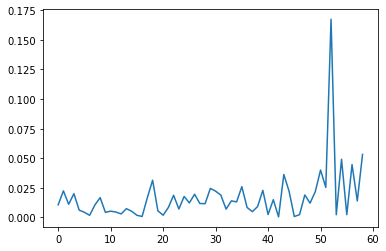

In [242]:
plt.plot(loaded_model.feature_importances_)

### Start feature importances plots

In [243]:
modelpath1 = 'rf_models/esti_200/y1' 
if not os.path.exists(modelpath1):
    os.makedirs(modelpath1)
    
modelpath2 = 'rf_models/esti_200/y2' 
if not os.path.exists(modelpath2):
    os.makedirs(modelpath2)
    
modelpath3 = 'rf_models/esti_200/y3' 
if not os.path.exists(modelpath3):
    os.makedirs(modelpath3)
    
modelpath4 = 'rf_models/esti_200/y4' 
if not os.path.exists(modelpath4):
    os.makedirs(modelpath4)
    
figpath = 'plots/' 
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [269]:
%%time
regr_dict_y1 = {}
feature_imp_y1 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    if os.path.isfile("rf_models/esti_200/y1/"+ str(key)+"_model_y1.sav"):
        with open("rf_models/esti_200/y1/"+ str(key)+"_model_y1.sav", 'rb') as fin:
            regr_dict_y1[key] = pickle.load(fin)
            feature_imp_y1[key] = regr_dict_y1[key].feature_importances_
    else:
        regr_dict_y1[key] = regr.fit(X_dict[key].drop(['playerId'], axis = 1), y[y['playerId'] == key]['target1'])
        feature_imp_y1[key] = regr_dict_y1[key].feature_importances_
        filename = str(key)+'_model_y1.sav'
        pickle.dump(regr_dict_y1[key], open(modelpath1 +'/'+ filename, 'wb'))

Wall time: 43.9 s


<AxesSubplot:>

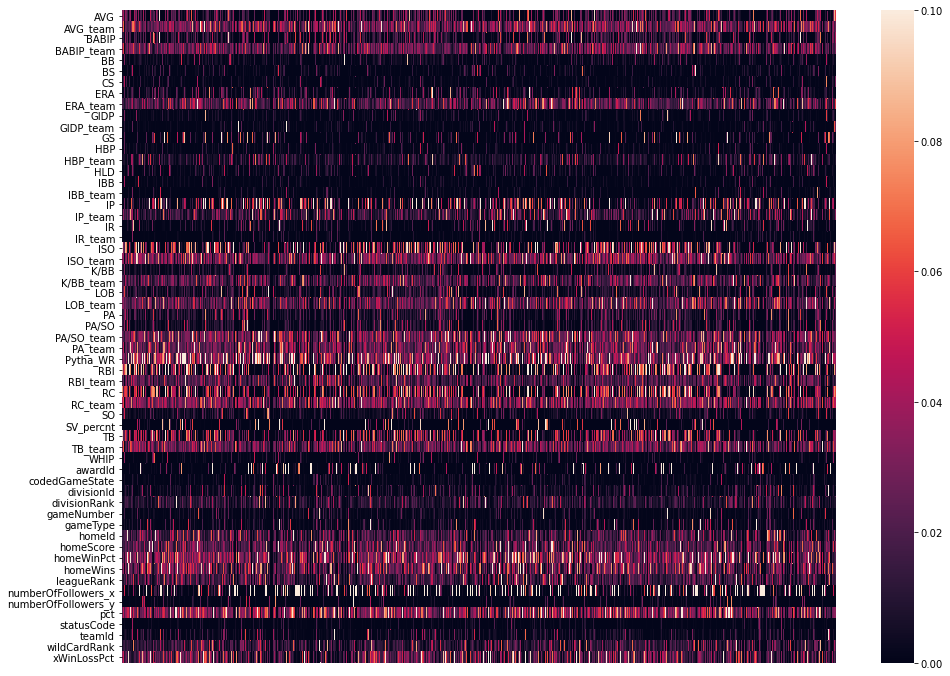

In [282]:
plt.figure(figsize = (16,12))
sns.heatmap(feature_imp_y1, vmax = 0.1, xticklabels=False)
# plt.savefig('plots/y1_200.jpg')

In [313]:
%%time
regr_dict_y2 = {}
feature_imp_y2 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    regr_dict_y2[key] = regr.fit(X_dict[key].drop(
        ['playerId'], axis = 1), y[y['playerId'] == key]['target2'])
    feature_imp_y2[key] = regr_dict_y2[key].feature_importances_
    filename = str(key)+'_model_y2.sav'
    pickle.dump(regr_dict_y2[key], open(modelpath1 +'/'+filename, 'wb'))

In [271]:
%%time
regr_dict_y2 = {}
feature_imp_y2 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    if os.path.isfile("rf_models/esti_200/y2/"+ str(key)+"_model_y2.sav"):
        with open("rf_models/esti_200/y2/"+ str(key)+"_model_y2.sav", 'rb') as fin:
            regr_dict_y2[key] = pickle.load(fin)
            feature_imp_y2[key] = regr_dict_y2[key].feature_importances_
    else:
        regr_dict_y2[key] = regr.fit(X_dict[key].drop(['playerId'], axis = 1), y[y['playerId'] == key]['target2'])
        feature_imp_y2[key] = regr_dict_y2[key].feature_importances_
        filename = str(key)+'_model_y2.sav'
        pickle.dump(regr_dict_y2[key], open(modelpath2 +'/'+ filename, 'wb'))

Wall time: 8min 52s


<AxesSubplot:>

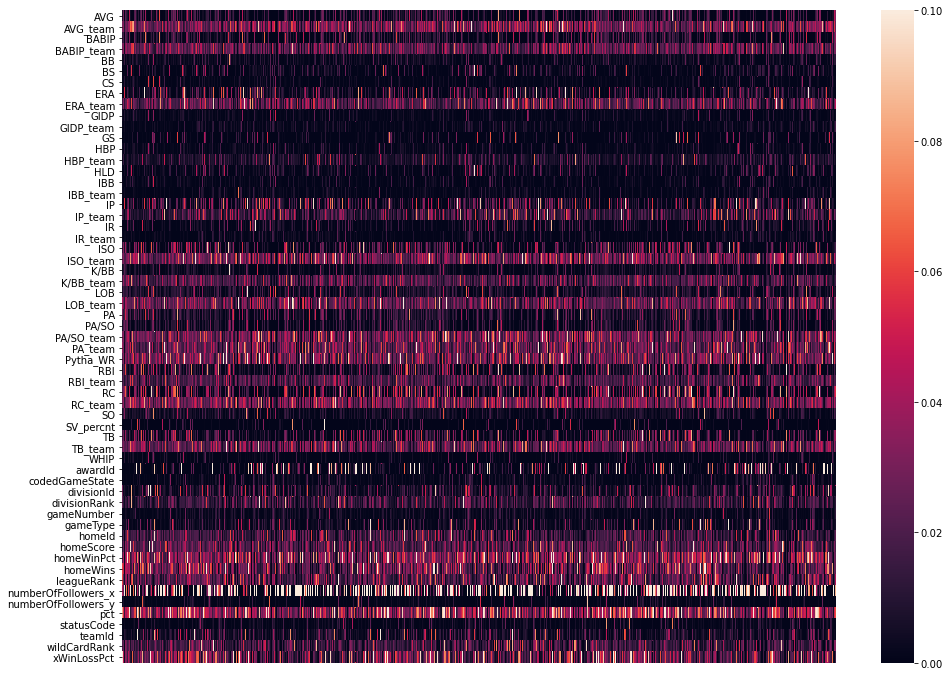

In [283]:
plt.figure(figsize = (16,12))
sns.heatmap(feature_imp_y2, vmax = 0.1, xticklabels=False)
# plt.savefig('plots/y2_200.jpg')

In [315]:
%%time
regr_dict_y3 = {}
feature_imp_y3 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    regr_dict_y3[key] = regr.fit(X_dict[key].drop(
        ['playerId'], axis = 1), y[y['playerId'] == key]['target3'])
    feature_imp_y3[key] = regr_dict_y3[key].feature_importances_
    filename = modelpath3 + str(key)+'_model_y3.sav'
    pickle.dump(regr_dict_y3[key], open(modelpath3 +'/'+filename, 'wb'))

In [273]:
%%time
regr_dict_y3 = {}
feature_imp_y3 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    if os.path.isfile("rf_models/esti_200/y3/"+ str(key)+"_model_y3.sav"):
        with open("rf_models/esti_200/y3/"+ str(key)+"_model_y3.sav", 'rb') as fin:
            regr_dict_y3[key] = pickle.load(fin)
            feature_imp_y3[key] = regr_dict_y3[key].feature_importances_
    else:
        regr_dict_y3[key] = regr.fit(X_dict[key].drop(['playerId'], axis = 1), y[y['playerId'] == key]['target3'])
        feature_imp_y3[key] = regr_dict_y3[key].feature_importances_
        filename = str(key)+'_model_y3.sav'
        pickle.dump(regr_dict_y3[key], open(modelpath3 +'/'+ filename, 'wb'))

Wall time: 8min 56s


<AxesSubplot:>

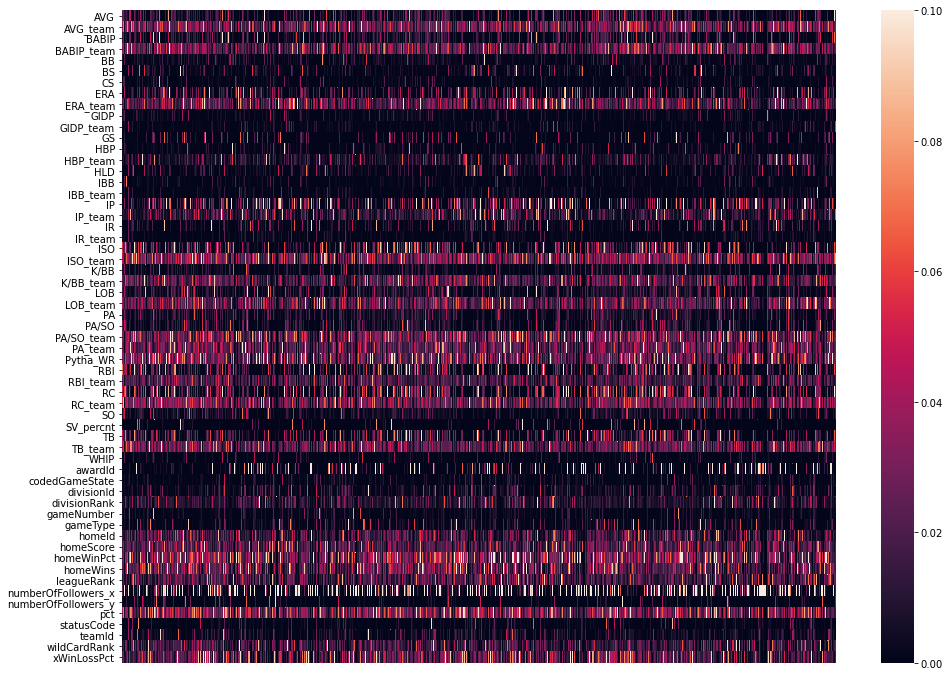

In [284]:
plt.figure(figsize = (16,12))
sns.heatmap(feature_imp_y3, vmax = 0.1, xticklabels=False)
# plt.savefig('plots/y3_200.jpg')

In [317]:
%%time
regr_dict_y4 = {}
feature_imp_y4 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    regr_dict_y4[key] = regr.fit(X_dict[key].drop(
        ['playerId'], axis = 1), y[y['playerId'] == key]['target4'])
    feature_imp_y4[key] = regr_dict_y4[key].feature_importances_
    filename = modelpath4 + str(key)+'_model_y4.sav'
    pickle.dump(regr_dict_y4[key], open(modelpath4 +'/'+filename, 'wb'))

In [275]:
%%time
regr_dict_y4 = {}
feature_imp_y4 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    if os.path.isfile("rf_models/esti_200/y4/"+ str(key)+"_model_y4.sav"):
        with open("rf_models/esti_200/y4/"+ str(key)+"_model_y4.sav", 'rb') as fin:
            regr_dict_y4[key] = pickle.load(fin)
            feature_imp_y4[key] = regr_dict_y4[key].feature_importances_
    else:
        regr_dict_y4[key] = regr.fit(X_dict[key].drop(['playerId'], axis = 1), y[y['playerId'] == key]['target4'])
        feature_imp_y4[key] = regr_dict_y4[key].feature_importances_
        filename = str(key)+'_model_y4.sav'
        pickle.dump(regr_dict_y4[key], open(modelpath4 +'/'+ filename, 'wb'))

Wall time: 8min 58s


<AxesSubplot:>

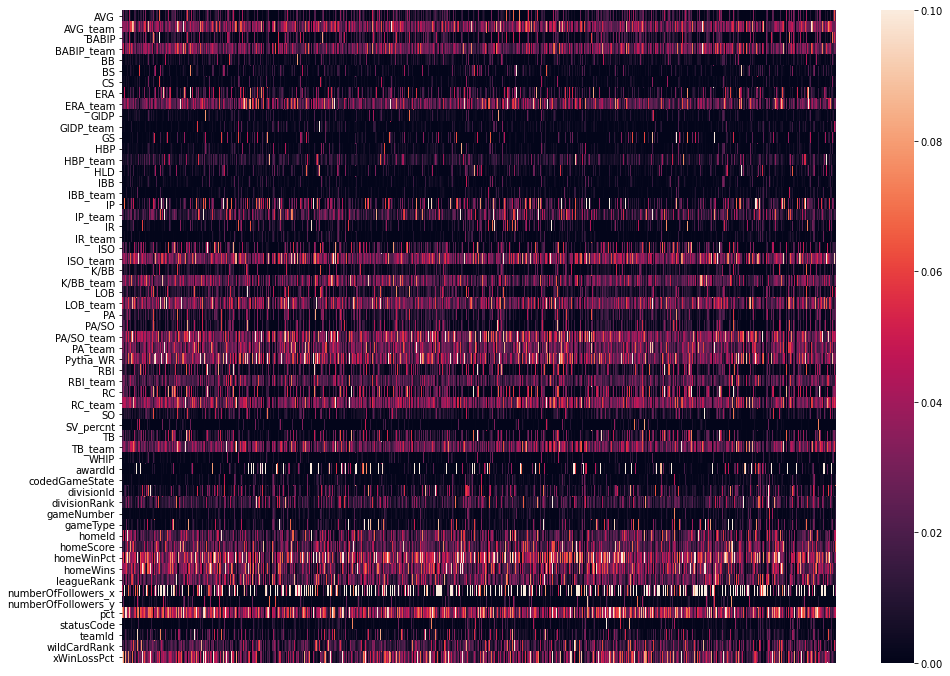

In [285]:
plt.figure(figsize = (16,12))
sns.heatmap(feature_imp_y4, vmax = 0.1, xticklabels=False)
# plt.savefig('plots/y4_200.jpg')

### Add twitter columns 